In [1]:
import sys
spath = '../'
sys.path.insert(0,spath)
from scripts.models import get_rttm_segments_features, sort_segments_by_speakers, Ivector
from scripts.notebook import\
get_first_speakers,\
limit_speakers_names,\
get_speakers_segments_indexes,\
get_speakers_models,\
get_speakers_permutations

import itertools
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

### Loading data from drive

In [2]:
dev_rttm     = '../exp/dihardii/development/ref_augmented_0_1.5_0.5_0.5.rttm'
dev_segments = '../exp/dihardii/development/augmented_0/segments'
dev_ivectors = '../exp/dihardii/development/augmented_0/exp/make_ivectors/ivector.txt'
dev_files_segments = get_rttm_segments_features(dev_rttm, dev_segments, dev_ivectors)

In [3]:
eval_rttm     = '../exp/dihardii/evaluation/ref_augmented_0_1.5_0.5_0.5.rttm'
eval_segments = '../exp/dihardii/evaluation/augmented_0/segments'
eval_ivectors = '../exp/dihardii/evaluation/augmented_0/exp/make_ivectors/ivector.txt'
eval_files_segments = get_rttm_segments_features(eval_rttm, eval_segments, eval_ivectors)

### Filtering data

In [4]:
dev_files_speakers = get_first_speakers(dev_files_segments, 2)
eval_files_speakers = get_first_speakers(eval_files_segments, 2)

delete = [file_id for file_id, speakers_names in dev_files_speakers.items() if len(speakers_names) < 2]
for file_id in delete:
    del dev_files_speakers[file_id]
delete = [file_id for file_id, speakers_names in eval_files_speakers.items() if len(speakers_names) < 2]
for file_id in delete:
    del eval_files_speakers[file_id]

dev_files_segments_lim = limit_speakers_names(dev_files_segments, dev_files_speakers, log = True)
eval_files_segments_lim = limit_speakers_names(eval_files_segments, eval_files_speakers, log = True)

Kept 49565 of 94517: 0.5244030174465969
Kept 45239 of 88018: 0.5139744143243428


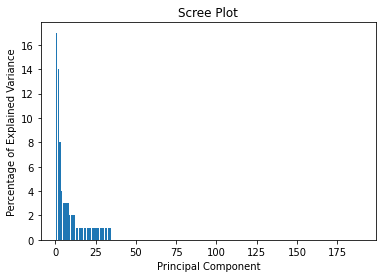

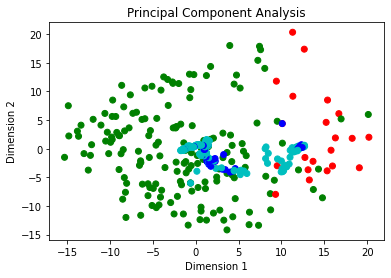

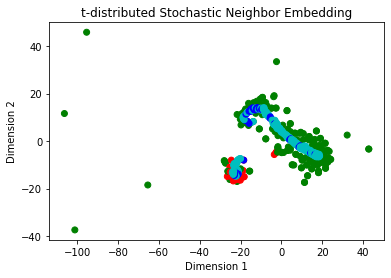

In [12]:
file_id = list(dev_files_segments_lim.keys())[0]
segments = dev_files_segments_lim[file_id]

x, y = zip(*[(segment.get_ivectors()[0].get_value(), segment.get_speakers()[0].get_name())\
        for segment in segments if len(segment.get_speakers()) == 1])
x, y = list(x), list(y)

speakers_ivectors = {}
speakers_models = {}
y_ = []
for segment in segments:
    if segment.get_speakers()[0].get_name() not in speakers_ivectors:
        speakers_ivectors[segment.get_speakers()[0].get_name()] = []
        speakers_models[segment.get_speakers()[0].get_name()] = []
    speakers_ivectors[segment.get_speakers()[0].get_name()].append(segment.get_ivectors()[0].get_value())
    speakers_models[segment.get_speakers()[0].get_name()].append(np.sum(speakers_ivectors[segment.get_speakers()[0].get_name()], 0) / len(speakers_ivectors[segment.get_speakers()[0].get_name()]))
    y_.append(segment.get_speakers()[0].get_name() + '_m')
x_ = list(itertools.chain(*speakers_models.values()))

data = pd.DataFrame(x)

scaler = preprocessing.StandardScaler()
scaler.fit(data)
scaled_data = scaler.transform(data)

pca = PCA()
pca.fit(scaled_data)

data_ = pd.DataFrame(x_)
scaled_data_ = scaler.transform(data_)

pca_data = pd.DataFrame(pca.transform(np.concatenate([scaled_data, scaled_data_])))

pca_data['label'] = y + y_

per_var = np.round(pca.explained_variance_ratio_ * 100) 
plt.bar(x = range(1, len(per_var) + 1), height = per_var)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

colors = ['r', 'g', 'b', 'c']
labels_colors = {}
for label in pca_data['label']:
    if label not in labels_colors:
        labels_colors[label] = colors.pop(0)
colors = [labels_colors[label] for label in pca_data['label']]
plt.scatter(pca_data[0], pca_data[1], c = colors)
plt.ylabel('Dimension 2')
plt.xlabel('Dimension 1')
plt.title('Principal Component Analysis')
plt.show()

tsne = TSNE()
tsne_data = pd.DataFrame(tsne.fit_transform(np.concatenate([scaled_data, scaled_data_])))
plt.scatter(tsne_data[0], tsne_data[1], c = colors)
plt.ylabel('Dimension 2')
plt.xlabel('Dimension 1')
plt.title('t-distributed Stochastic Neighbor Embedding')
plt.show()

In [6]:
from torch.utils.data import Dataset
import numpy

class Files_dataset(Dataset):
    def __init__(self,
                 files_segments,
                 models_generation_lengths = [3],
                 models_container_length = 2,
                 include_zeros = True,
                 include_overlaps = False,
                 feature='ivectors'):
        self.files_segments = files_segments
        self.include_overlaps = include_overlaps
        self.feature = feature
        self.speakers_segments_indexes = {}
        self.speakers_models = {}
        self.speakers_permutations = {}
        self.lookup = []
        self.length = 0
        for file_id, segments in self.files_segments.items():
            self.speakers_segments_indexes[file_id] = get_speakers_segments_indexes(enumerate(segments))
            self.speakers_models[file_id] = get_speakers_models(segments,
                                                                self.speakers_segments_indexes[file_id],
                                                                models_generation_lengths)
            self.speakers_permutations[file_id] = get_speakers_permutations(self.speakers_models[file_id],
                                                                            models_container_length,
                                                                            include_zeros,
                                                                            include_overlaps)
            for index, permutation in enumerate(self.speakers_permutations[file_id]):
                models_length = numpy.prod([len(self.speakers_models[file_id][speakers_names].keys())\
                if speakers_names != '0' else 1 for speakers_names in permutation])
                length = models_length * len(segments)
                self.lookup.append({\
                                    'file_id': file_id,\
                                    'permutation_index': index,\
                                    'models_length': models_length,\
                                    'segments_length': len(segments),\
                                    'permutation_length': length,\
                                    'onset': self.length,\
                                    'end': self.length + length - 1 })
                self.length += length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        lookup = [value for value in self.lookup if value['onset'] <= idx and idx <= value['end']][0]
        index = idx - lookup['onset']
        permutation = self.speakers_permutations[lookup['file_id']][lookup['permutation_index']]
        remainder, segment_index = divmod(index, lookup['segments_length'])
        models_container = []
        for index, speakers_names in enumerate(permutation):
            models_lengths = [len(self.speakers_models[lookup['file_id']][speakers_names].keys()) if speakers_names != '0' else 1 for speakers_names in permutation][index + 1:]
            if index != len(permutation) - 1:
                model_index, remainder = divmod(remainder, int(numpy.prod(models_lengths)))
            else:
                model_index = remainder
            if speakers_names != '0':
                models_container.append(self.speakers_models[lookup['file_id']][speakers_names][list(self.speakers_models[lookup['file_id']][speakers_names].keys())[model_index]])
            else:
                # TODO: improve
                models_container.append({ 'ivectors': [Ivector(numpy.random.uniform(-0.1, 0.1, 400).astype(numpy.float32))] })
        segment = self.files_segments[lookup['file_id']][segment_index]
        segment_speakers = [speaker.get_name() for speaker in segment.get_speakers()]
        x = [value[self.feature][0].get_value() for value\
             in models_container + [{ 'ivectors': segment.get_ivectors() }]]
        if self.include_overlaps:
            segment_speakers = ','.join(sorted(set(segment_speakers)))
            y = numpy.asarray([speakers_names == segment_speakers for speakers_names in permutation], dtype = numpy.float32)
        else:
            y = numpy.asarray([speakers_names in segment_speakers for speakers_names in permutation], dtype = numpy.float32) / len(segment_speakers)
        return x, y

In [7]:
'''import pytorch_lightning
import torch
torch.set_default_tensor_type(torch.cuda.FloatTensor)
from torch.utils.data import DataLoader

class DNNModel(pytorch_lightning.LightningModule):

    def __init__(self):
        super().__init__()
        m = 400 # embedding length
        n = 2   # models container length
        self.cnn1 = torch.nn.Sequential(
            torch.nn.Conv1d((n + 1), n ** 3, 3),
            torch.nn.ReLU(),
            torch.nn.Conv1d(n ** 3, n ** 2, 3),
            torch.nn.ReLU(),
            torch.nn.Conv1d(n ** 2, n, 3),
            torch.nn.ReLU(),
        )
        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear((m - 6) * n, n * 32),
            torch.nn.ReLU(),
            torch.nn.Linear(n * 32, n * 16),
            torch.nn.ReLU(),
            torch.nn.Linear(n * 16, n),
            torch.nn.Sigmoid(),
        )

    def forward(self, x):
        x = torch.stack(x, 1)
        x = self.cnn1(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        return x

    def training_step(self, batch, batch_nb):
        x, y = batch
        criterion = torch.nn.BCELoss()
        loss = criterion(self(x), y)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr = 0.0001)'''

"import pytorch_lightning\nimport torch\ntorch.set_default_tensor_type(torch.cuda.FloatTensor)\nfrom torch.utils.data import DataLoader\n\nclass DNNModel(pytorch_lightning.LightningModule):\n\n    def __init__(self):\n        super().__init__()\n        m = 400 # embedding length\n        n = 2   # models container length\n        self.cnn1 = torch.nn.Sequential(\n            torch.nn.Conv1d((n + 1), n ** 3, 3),\n            torch.nn.ReLU(),\n            torch.nn.Conv1d(n ** 3, n ** 2, 3),\n            torch.nn.ReLU(),\n            torch.nn.Conv1d(n ** 2, n, 3),\n            torch.nn.ReLU(),\n        )\n        self.fc1 = torch.nn.Sequential(\n            torch.nn.Linear((m - 6) * n, n * 32),\n            torch.nn.ReLU(),\n            torch.nn.Linear(n * 32, n * 16),\n            torch.nn.ReLU(),\n            torch.nn.Linear(n * 16, n),\n            torch.nn.Sigmoid(),\n        )\n\n    def forward(self, x):\n        x = torch.stack(x, 1)\n        x = self.cnn1(x)\n        x = x.view(x

In [8]:
'''train_loader = DataLoader(Files_dataset(dev_files_segments_lim),
                          batch_size = 32,
                          shuffle = True)

model = DNNModel()
trainer = pytorch_lightning.Trainer(gpus = 1, progress_bar_refresh_rate = 20)    
trainer.fit(model, train_loader)'''

'train_loader = DataLoader(Files_dataset(dev_files_segments_lim),\n                          batch_size = 32,\n                          shuffle = True)\n\nmodel = DNNModel()\ntrainer = pytorch_lightning.Trainer(gpus = 1, progress_bar_refresh_rate = 20)    \ntrainer.fit(model, train_loader)'